In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shap
import sys
import os

# Add src to path to import custom modules
sys.path.append(os.path.abspath('../src'))

from churn.preprocessing import load_data

# Settings
sns.set_theme(style="whitegrid")

# Suppress specific warnings for cleaner output
warnings.filterwarnings('ignore', message='.*LightGBM binary classifier.*')
warnings.filterwarnings('ignore', message='.*X does not have valid feature names.*')

## Load Production Model & Data
We load the **saved pipeline** (`lightgbm_pipeline.joblib`) to ensure we explain exactly what is deployed in the API.

In [2]:
# Load Model, Data Cleaner and Data
pipeline = joblib.load('../models/lightgbm_pipeline.joblib')
cleaner = joblib.load('../models/data_cleaner.joblib') # Load the cleaner to fix data types
df = load_data('../data/Telco-Customer-Churn.csv')

# Separate Target
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

# Apply Data Cleaning (Fixes ' ' strings in TotalCharges and handles IDs)
X_clean, y_clean = cleaner.transform(X, y)

# Extract Preprocessor and Model from Pipeline
preprocessor = pipeline.named_steps['preprocessor']
model = pipeline.named_steps['classifier']

# Transform Data
# We use X_clean here (not raw X) because preprocessor expects numeric TotalCharges
X_transformed = preprocessor.transform(X_clean)

# Recover Feature Names
feature_names = preprocessor.get_feature_names_out()

# Convert back to DataFrame for SHAP
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

print(f"Model loaded: {type(model)}")
print(f"Transformed Data Shape: {X_transformed_df.shape}")

Model loaded: <class 'lightgbm.sklearn.LGBMClassifier'>
Transformed Data Shape: (7032, 22)


## Global Feature Importance (Summary Plot)
This plot ranks features by their impact on the model's output.
*   **Y-axis:** Features ranked by importance.
*   **X-axis:** SHAP value (impact on churn probability). Positive = Higher Risk.
*   **Color:** Feature value (Red = High, Blue = Low).

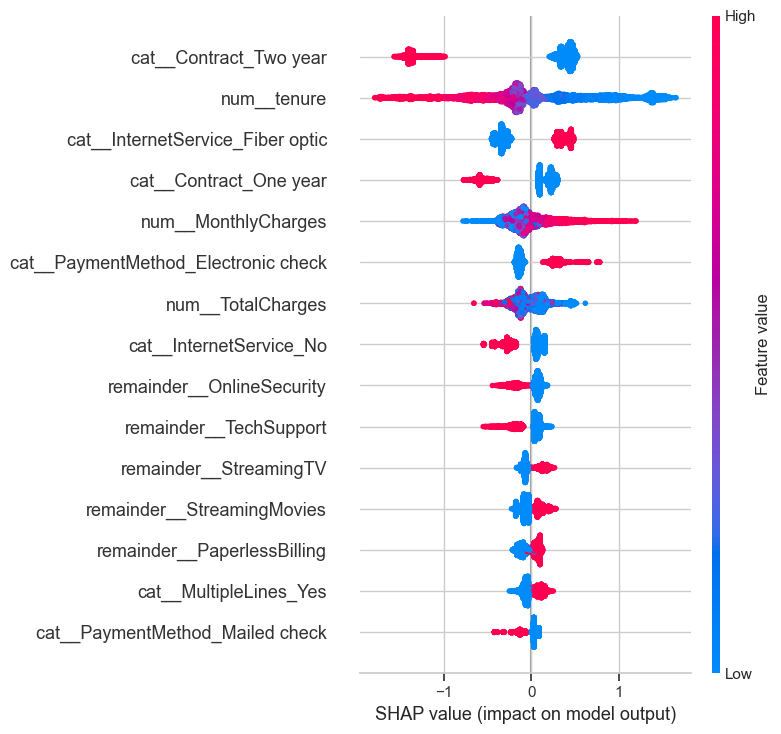

In [3]:
# Create SHAP Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed_df)

# Summary Plot
plt.figure(figsize=(10, 8))
# LightGBM binary classification returns a list of arrays, so we need index 1 (Positive Class)
shap_values_churn = shap_values[1] if isinstance(shap_values, list) else shap_values

shap.summary_plot(shap_values_churn, X_transformed_df, plot_type="dot", max_display=15)

1.  **Long-term Contracts (Top Feature):** The most influential factor is `Contract_Two year`. Red dots (presence of a 2-year contract) are heavily on the left (negative values), meaning these contracts are the strongest shield against churn.
2.  **Tenure:** Clear trend - red dots (long tenure) reduce risk, while blue dots (short tenure) increase it significantly.
3.  **Fiber Optic:** The presence of `Fiber optic` (red dots on the right) increases the probability of churn. This suggests customers on this plan are more likely to leave, possibly due to price or service issues.
4.  **Monthly Charges:** Generally, higher charges (red) are associated with higher churn risk (right side), while lower charges (blue) reduce it.

## Feature Dependence (Non-linearities)
How does **Monthly Charges** affect churn? Is it a linear relationship?

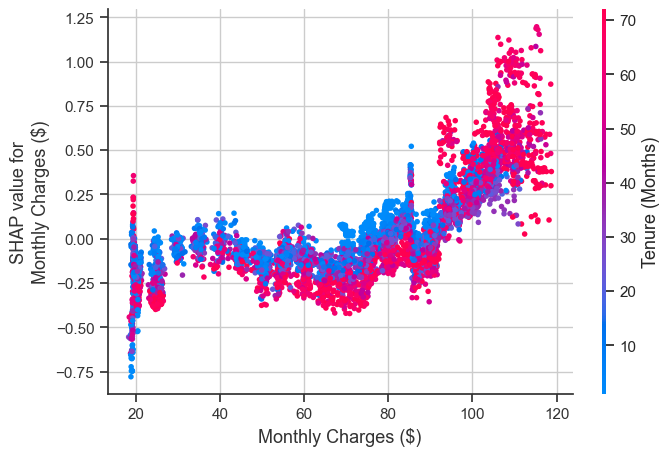

In [4]:
# Create a display dataframe
X_display = X_transformed_df.copy()

# Rename columns for better plot labels
X_display = X_display.rename(columns={
    'num__MonthlyCharges': 'Monthly Charges ($)',
    'num__tenure': 'Tenure (Months)'
})

# Force overwrite with Raw numeric values
X_display['Monthly Charges ($)'] = X_clean['MonthlyCharges'].values
X_display['Tenure (Months)'] = X_clean['tenure'].values

# Plot dependence
shap.dependence_plot(
    "Monthly Charges ($)", 
    shap_values_churn, 
    X_display,
    interaction_index="Tenure (Months)"
)

> *   **(< $60):** Charges below $60 are associated with lower churn risk (SHAP values < 0).
> *   **($70 - $100):** Risk increases sharply in this range. Notice that **Blue dots (New customers)** often float higher than Red dots (Loyal customers) in the $80-$90 range. This indicates that *high tenure* acts as a buffer against price sensitivity in the mid-to-high price range.
> *   **(> $100):** At the extreme high end, the risk is maximal (SHAP > 1.0). Interestingly, this segment is dominated by **Red dots (High Tenure)**: even long-term customers will leave if the price becomes excessive.

## Local Interpretability (Why did *this* user leave?)
Let's pick a high-risk customer and see the specific factors.

Analyzing Customer #2203
Actual Probability: 0.97


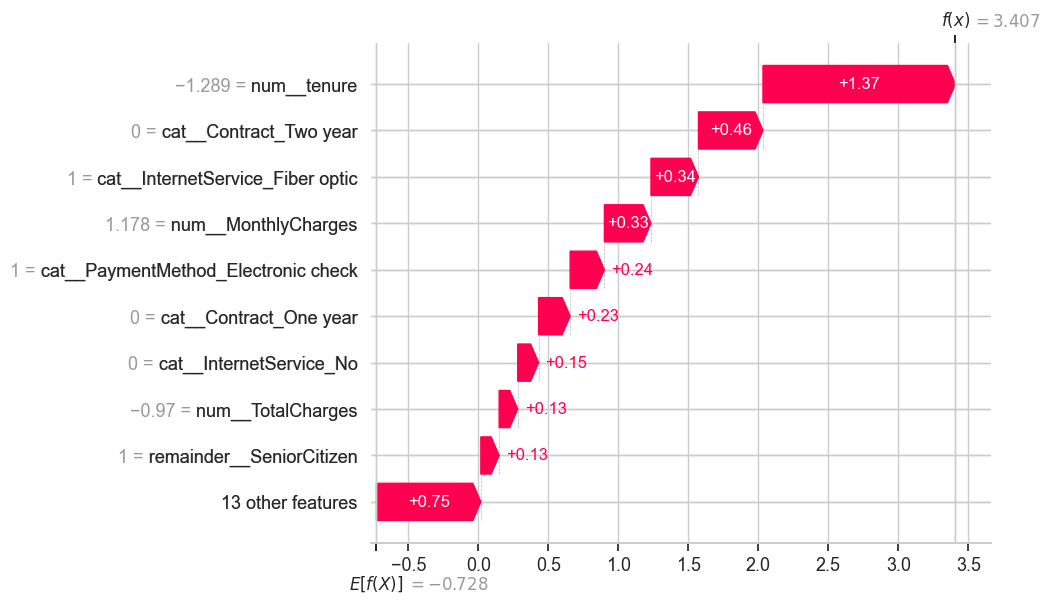

In [5]:
# Find a customer with high probability of churn
# Using X_clean as input for the full pipeline
y_pred_proba = pipeline.predict_proba(X_clean)[:, 1]
high_risk_idx = np.argmax(y_pred_proba) # Index of highest risk customer

print(f"Analyzing Customer #{high_risk_idx}")
print(f"Actual Probability: {y_pred_proba[high_risk_idx]:.2f}")

# Waterfall Plot
explanation = explainer(X_transformed_df)

# Fix for LightGBM binary output dimension
if len(explanation.shape) == 3:
    explanation = explanation[:, :, 1] # Take positive class

shap.plots.waterfall(explanation[high_risk_idx])

## Business Ideas based on SHAP results

1.  **Migrate Month-to-Month Users:** The lack of a long-term contract is the #1 risk factor.
    *   **Action:** Launch a targeted campaign offering a "1st Month Free" incentive for switching to a 1-Year Contract.

2.  **Review High-End Pricing ($100+):** Customers are churning at very high price points (> $100).
    *   **Action:** Create a "Loyalty Cap" or bundle discount to ensure bill shock doesn't drive away most valuable long-term users.

3.  **Fiber Optic Service Check:** Fiber Optic users are consistently riskier.
    *   **Action:** Conduct a technical audit in regions with high Fiber churn. If service is stable, the issue is price/value perception.